In [1]:
import copy
import shutil
from pathlib import Path

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sparse
import torch
import torch.nn.functional as F
from medclip import MedCLIPModel, MedCLIPVisionModel
from PIL import Image, ImageOps
from pydicom import dcmread
from rich import print
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.ops import roi_align
from tqdm.auto import tqdm

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualize Sample Data


In [2]:
DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5"
IMAGE_ID = 0

(3, 84, 84)

IMAGE:

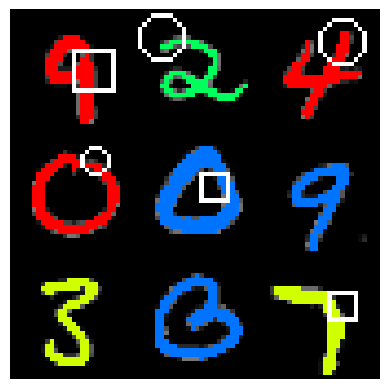

TEXT: the shape size is large . the shape is large . the shape appears to be a circle . the number is a three . 
there is a red image . the size of the shape is large . there is a rectangle . there is an image showing a seven . 
the shape size is medium . the digit appears to be blue . there is an image showing a nine . the number is a zero .
there is an image showing a three . the image has a rectangle . the image shows a zero . the image is red . the 
shape appears to be a rectangle . the digit appears to be green . the digit appears to be red . the number is a two
. the image has a circle . the image shows a four . the image is yellow . there is a circle . the image shows a 
nine . the shape is medium

REGION-ATTRIBUTE PAIRS:

REGION 1: ['nine' 'red' 'rectangle' 'large']

REGION 2: ['two' 'green' 'circle' 'large']

REGION 3: ['four' 'red' 'circle' 'large']

REGION 4: ['zero' 'red' 'circle' 'medium']

REGION 5: ['zero' 'blue' 'rectangle' 'medium']

REGION 6: ['nine' 'blue']

REGION 7: ['three' 'yellow']

REGION 8: ['three' 'blue']

REGION 9: ['seven' 'yellow' 'rectangle' 'medium']

In [3]:
# Load image and annotations
img = sparse.load_npz(f"{DATA_DIR}/images/{IMAGE_ID}.npz").todense() / 255
print(img.shape)
df = pd.read_feather(f"{DATA_DIR}/annotations.feather")
row = df[df["image_id"] == IMAGE_ID]

# Print image
print("IMAGE:")
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis(False)
plt.show()

# Print text
caption = row["text"].values[0]
print("TEXT:", caption)

# Print region-attribute pairs
print("REGION-ATTRIBUTE PAIRS:")
mappings = row["reg_to_attr"].values[0]
for i in range(len(mappings)):
    print(f"\tREGION {i+1}:", mappings[i])

In [13]:
DATA_DIR = "C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5"
df = pd.read_feather(f"{DATA_DIR}/annotations.feather")

In [14]:
df

,image_id,image_size,image_filepath,region_coord,num_regions,split,text,digit_label,color_label,shape_label,size_label,reg_to_attr,attributes
0,0,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,the shape size is large . the shape is large ....,"[nine, two, four, zero, zero, nine, three, thr...","[red, green, red, red, blue, blue, yellow, blu...","[rectangle, circle, circle, circle, rectangle,...","[large, large, large, medium, medium, None, No...","[[nine, red, rectangle, large], [two, green, c...","[red, seven, yellow, circle, green, blue, larg..."
1,1,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,there is an image showing a four . there is a ...,"[six, zero, four, zero, one, eight, four, nine...","[purple, green, purple, yellow, green, blue, p...","[None, circle, circle, rectangle, None, circle...","[None, small, medium, large, None, medium, Non...","[[six, purple], [zero, green, circle, small], ...","[six, yellow, circle, small, one, green, blue,..."
2,2,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,train,the digit appears to be one . there is an imag...,"[zero, seven, five, nine, one, seven, one, six]","[green, yellow, yellow, green, red, red, yello...","[None, rectangle, rectangle, circle, circle, c...","[None, medium, large, small, medium, medium, m...","[[zero, green], [seven, yellow, rectangle, med...","[red, seven, yellow, six, circle, small, one, ..."
3,3,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,there is a red image . the number is a one . t...,"[six, zero, two, eight, five, two, one, eight,...","[purple, purple, yellow, red, purple, red, pur...","[rectangle, circle, None, rectangle, rectangle...","[small, large, None, large, small, None, None,...","[[six, purple, rectangle, small], [zero, purpl...","[red, six, yellow, small, circle, one, blue, g..."
4,4,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",9,train,the number is a zero . the image is yellow . t...,"[one, seven, three, six, five, seven, seven, n...","[yellow, yellow, blue, purple, red, yellow, gr...","[None, rectangle, circle, circle, None, rectan...","[None, large, small, large, None, small, large...","[[one, yellow], [seven, yellow, rectangle, lar...","[red, seven, yellow, six, circle, one, small, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10513,10513,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,there is a purple image . the size of the shap...,"[nine, eight, eight, four, nine, four, four, s...","[yellow, green, blue, yellow, blue, purple, bl...","[circle, circle, rectangle, None, circle, circ...","[large, large, medium, None, medium, large, me...","[[nine, yellow, circle, large], [eight, green,...","[purple, seven, yellow, circle, green, blue, l..."
10514,10514,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,the image has a circle . the image shows a fiv...,"[three, four, three, five, eight, two, six, one]","[purple, blue, green, red, yellow, green, purp...","[rectangle, rectangle, circle, circle, None, r...","[small, medium, medium, large, None, medium, s...","[[three, purple, rectangle, small], [four, blu...","[red, six, yellow, small, circle, one, blue, g..."
10515,10515,"[84, 84]",C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...,"[[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...",8,val,the size of the shape is medium . there is a c...,"[one, eight, zero, zero, four, five, two, one]","[yellow, green, purple, purple, purple, blue, ...","[rectangle, rectangle, rectangle, None, circle...","[medium, large, small, None, large, medium, la...

In [6]:
df["reg_to_attr"]

0        [[nine, red, rectangle, large], [two, green, c...
1        [[six, purple], [zero, green, circle, small], ...
2        [[zero, green], [seven, yellow, rectangle, med...
3        [[six, purple, rectangle, small], [zero, purpl...
4        [[one, yellow], [seven, yellow, rectangle, lar...
                               ...                        
10513    [[nine, yellow, circle, large], [eight, green,...
10514    [[three, purple, rectangle, small], [four, blu...
10515    [[one, yellow, rectangle, medium], [eight, gre...
10516    [[four, yellow], [eight, purple, circle, small...
10517    [[seven, yellow], [one, green, rectangle, smal...
Name: reg_to_attr, Length: 10518, dtype: object

In [7]:
df["num_regions"].mean()

8.853489256512646

In [8]:
df["num_regions"].value_counts()

num_regions
9    8977
8    1541
Name: count, dtype: int64

In [9]:
df.split.value_counts()

split
train    10179
val        339
Name: count, dtype: int64

In [10]:
df["region_coord"].iloc[0]

array([array([ 0,  0, 28, 28]), array([28,  0, 56, 28]),
       array([56,  0, 84, 28]), array([ 0, 28, 28, 56]),
       array([28, 28, 56, 56]), array([56, 28, 84, 56]),
       array([ 0, 56, 28, 84]), array([28, 56, 56, 84]),
       array([56, 56, 84, 84])], dtype=object)

### Generate Region Embeddings on Sample Data


In [150]:
model, _ = clip.load("RN50", "cuda")

In [151]:
model

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [208]:
def generate_region_embs(out_dir):
    """
    Generate embeddings for each region.

    Parameters:
        out_dir: Directory for storing region embeddings
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}
    out_dir = Path(out_dir) / "region_embs"
    if out_dir.exists() and out_dir.is_dir():
        shutil.rmtree(out_dir)
    out_dir.mkdir()

    # Load CLIP vision encoder
    model, _ = clip.load("RN50", "cuda")
    model_backbone, _ = clip.load("RN50", "cuda")
    components["model_backbone"] = model_backbone.to(torch.float32)
    for c in ["attnpool", "layer4"]:
        components[c] = copy.deepcopy(eval(f"model_backbone.visual.{c}"))
        setattr(model_backbone.visual, c, torch.nn.Identity())
    for c in ["transformer", "token_embedding", "ln_final"]:
        setattr(model_backbone, c, torch.nn.Identity())

    # Generate embeddings for each region
    reg_emb_map = {"image_id": [], "file": [], "file_id": []}
    all_reg_embs = []
    for idx, row in tqdm(ann.iterrows()):
        image_id, filepath = row["image_id"], row["image_filepath"]
        image = torch.tensor(
            (sparse.load_npz(filepath).todense() / 255).astype(np.float32)
        )
        image = torch.stack([image]).cuda()
        regions = np.stack(row["region_coord"].tolist())

        with torch.no_grad():
            features = components["model_backbone"].encode_image(image)
            rois = (
                torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
                .to(torch.float32)
                .cuda()
            )
            x = roi_align(
                features,
                rois.to(dtype=features.dtype),
                (14, 14),
                features.shape[-1] / image.shape[-1],
                0,
                True,
            )
            x = components["layer4"](x)
            x = components["attnpool"](x)
            # print(f"Shape of {idx} Embedding: {x.shape}")
            reg_embs = x

        if len(all_reg_embs) == 10000:
            all_reg_embs = np.array(all_reg_embs, dtype=object)
            print(f"Shape of all embeddings: {all_reg_embs.shape}")
            np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
            reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
            reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
            all_reg_embs = []
        reg_embs = reg_embs.cpu().numpy()
        all_reg_embs.append(
            reg_embs.reshape(
                -1,
            )
        )
        reg_emb_map["image_id"].append(image_id)

    all_reg_embs = np.array(all_reg_embs, dtype=object)
    np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
    reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
    reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

    pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
    print(f"Saved region embeddings to {out_dir}")

In [193]:
generate_region_embs("C:/Users/DryLab/Desktop/villa/data/docmnist_300000_29.5")

2388it [00:18, 131.63it/s]


Saved region embeddings to C:\Users\DryLab\Desktop\villa\data\open-i\region_embs

### Check shape of data and visualize the layer on one sample


In [209]:
def generate_region_embs(image_id, out_dir):
    """
    Generate embeddings for a single region using CLIP and print the shapes of the outputs.

    Parameters:
        image_id: ID of the image to process
        out_dir: Directory containing annotation file and image data
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}

    # Load CLIP vision encoder
    model, _ = clip.load("RN50", "cuda")
    model_backbone, _ = clip.load("RN50", "cuda")
    components["model_backbone"] = model_backbone.to(torch.float32)

    # Set a couple of components to identity, torch.nn.identity() is used to get the same results as the previous layer
    # which means we want to get the features before the attention pooling and layer 4

    # Copy attention pool and layer 4 components
    for c in ["attnpool", "layer4"]:
        components[c] = copy.deepcopy(eval(f"model_backbone.visual.{c}"))
        setattr(model_backbone.visual, c, torch.nn.Identity())

    # Set transformer-related components to identity
    for c in ["transformer", "token_embedding", "ln_final"]:
        setattr(model_backbone, c, torch.nn.Identity())

    # Find the row with the corresponding image_id
    row = ann[ann["image_id"] == image_id].iloc[0]
    filepath = row["image_filepath"]
    image = torch.tensor((sparse.load_npz(filepath).todense() / 255).astype(np.float32))
    print(image.shape)
    image = torch.stack([image]).cuda()
    print(image.shape)
    regions = np.stack(row["region_coord"].tolist())

    with torch.no_grad():
        # Generate image features
        print(f"Image shape: {image.shape}")
        features = components["model_backbone"].encode_image(image)
        print(f"Features shape: {features.shape}")

        # Process regions with ROI alignment
        rois = (
            torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
            .to(torch.float32)
            .cuda()
        )
        x = roi_align(
            features, rois, (14, 14), features.shape[-1] / image.shape[-1], 0, True
        )
        print(f"ROI-Aligned shape: {x.shape}")

        # Pass through layer4 and attention pooling
        x = components["layer4"](x)
        print(f"Layer4 shape: {x.shape}")
        x = components["attnpool"](x)
        print(f"Region embeddings shape: {x.shape}")

        return x


In [210]:
x = generate_region_embs(1, "C:/Users/DryLab/Desktop/ViLLA/data/docmnist_300000_29.5/")

torch.Size([3, 84, 84])

torch.Size([1, 3, 84, 84])

Image shape: torch.Size([1, 3, 84, 84])

Features shape: torch.Size([1, 1024, 5, 5])

ROI-Aligned shape: torch.Size([9, 1024, 14, 14])

Layer4 shape: torch.Size([9, 2048, 7, 7])

Region embeddings shape: torch.Size([9, 1024])

### Create Preprocessing Steps for X-Ray Images


In [144]:
def process_image_dicom(filepath):
    dicom = dcmread(filepath)
    image = dicom.pixel_array

    # Convert 16-bit image to 8-bit image
    image = cv2.normalize(
        image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U
    )

    # Invert the image if the background is white
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = Image.fromarray((image).astype(np.uint8)).convert("L")
        image = ImageOps.invert(image)
    else:
        image = Image.fromarray((image).astype(np.uint8)).convert("L")

    # Resize image
    image = image.resize((224, 224))

    # Convert Image object to numpy array and normalize
    image = np.array(image).astype(np.float32) / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(torch.float32)

    return image_tensor

In [211]:
def process_image(filepath):
    image = Image.open(filepath).convert("L")

    # Resize image
    image = image.resize((224, 224))

    # Convert Image object to numpy array
    image = np.array(image)

    # Normalize image
    image = image.astype(np.float32) / 255.0

    # Convert to tensor and add batch dimension
    image_tensor = torch.from_numpy(image).unsqueeze(0).to(torch.float32)

    return image_tensor

### Use MedCLIP to generate embeddings for one image and check the layer shape


In [257]:
def generate_region_embs(image_id, out_dir):
    """
    Generate embeddings for a single region using CLIP and print the shapes of the outputs.

    Parameters:
        image_id: ID of the image to process
        out_dir: Directory containing annotation file and image data
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}

    # Load MedCLIP vision encoder
    model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
    model.from_pretrained()
    image_encoder = model.vision_model
    image_encoder = image_encoder.to("cuda")

    for layer in ["layer4", "avgpool", "fc"]:
        components[layer] = copy.deepcopy(eval(f"image_encoder.model.{layer}"))
        setattr(image_encoder.model, layer, torch.nn.Identity())

    # Find the row with the corresponding image_id
    row = ann[ann["image_id"] == image_id].iloc[0]
    filepath = row["image_filepath"]
    image = process_image(filepath)
    print(image.shape)
    image = torch.stack([image]).cuda()
    print(image.shape)
    regions = np.stack(row["region_bbox"].tolist())

    with torch.no_grad():
        # Generate image features
        print(f"Image shape: {image.shape}")
        features = image_encoder.forward(image)
        print(f"Features shape: {features.shape}")

        # Process regions with ROI alignment
        rois = (
            torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
            .to(torch.float32)
            .cuda()
        )
        x = roi_align(
            features, rois, (14, 14), features.shape[-1] / image.shape[-1], 0, True
        )
        print(f"ROI-Aligned shape: {x.shape}")

        # Pass through layer4 and attention pooling
        x = components["layer4"](x)
        print(f"Layer4 shape: {x.shape}")
        x = components["avgpool"](x)
        x = x.flatten(1)
        print(f"Region embeddings shape: {x.shape}")

        return x


In [258]:
x = generate_region_embs(1, "C:/Users/DryLab/Desktop/ViLLA/data/open-i/")

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

load model weight from: ./pretrained/medclip-resnet


torch.Size([1, 224, 224])

torch.Size([1, 1, 224, 224])

Image shape: torch.Size([1, 1, 224, 224])

Features shape: torch.Size([1, 1024, 14, 14])

ROI-Aligned shape: torch.Size([3, 1024, 14, 14])

Layer4 shape: torch.Size([3, 2048, 7, 7])

Region embeddings shape: torch.Size([3, 2048])

### Use Mask directly to generate region embeddings


In [848]:
# def generate_region_embs(out_dir):
#     """
#     Generate embeddings for each region using MedCLIP.

#     Parameters:
#         out_dir: Directory for storing region embeddings
#     """
#     ann = pd.read_feather(f"{out_dir}/annotations.feather")
#     components = {}
#     out_dir = Path(out_dir) / "region_embs"
#     if out_dir.exists() and out_dir.is_dir():
#         shutil.rmtree(out_dir)
#     out_dir.mkdir()

#     # Load MedCLIP vision encoder
#     model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
#     model.from_pretrained()
#     image_encoder = model.vision_model
#     image_encoder = image_encoder.to("cuda")

#     for layer in ["layer3", "avgpool"]:
#         components[layer] = copy.deepcopy(getattr(image_encoder.model, layer))
#         setattr(image_encoder.model, layer, torch.nn.Identity())
#     for layer in ["layer4", "fc"]:
#         setattr(image_encoder.model, layer, torch.nn.Identity())

#     # Prepare to store the embeddings
#     reg_emb_map = {"image_id": [], "file": [], "file_id": []}
#     all_reg_embs = []

#     # Generate embeddings for each region
#     for idx, row in tqdm(ann.iterrows(), total=len(ann)):
#         image_id, filepath = row["image_id"], row["image_filepath"]
#         # Load and resize the image
#         image = process_image(filepath).cuda()
#         regions = row["region_coord"]  # These are the multiclass masks

#         with torch.no_grad():
#             # Generate image features
#             features = image_encoder(image)

#             # Initialize a list to store region embeddings for each class
#             all_class_embs = []

#             for mask in regions:
#                 # Convert mask to a tensor
#                 mask_tensor = torch.tensor(
#                     mask.reshape(224, 224), dtype=torch.float32
#                 ).cuda()

#                 # print(f"Mask tensor shape: {mask_tensor.shape}")

#                 # Resize the mask to match the feature map size
#                 mask_tensor = F.interpolate(
#                     mask_tensor.unsqueeze(0).unsqueeze(0),
#                     size=features.shape[-2:],
#                     mode="nearest",
#                 )

#                 # print(f"Mask tensor after reshape: {mask_tensor.shape}")

#                 # Apply the mask to the feature map
#                 masked_features = features * mask_tensor
#                 # print(f"Masked features shape: {masked_features.shape}")
#                 # Perform global average pooling on the masked features
#                 masked_features = components["layer3"](masked_features)
#                 pooled_features = (
#                     components["avgpool"](masked_features).squeeze(-1).squeeze(-1)
#                 )
#                 # print(f"Pooled features shape: {pooled_features.shape}")
#                 all_class_embs.append(pooled_features)

#             # Concatenate embeddings for all classes
#             reg_embs = torch.cat(all_class_embs, dim=0).cpu().numpy()
#             # print(f"Final region embeddings shape: {reg_embs.shape}")
#             all_reg_embs.append(reg_embs.reshape(-1))

#             if len(all_reg_embs) >= 1000:
#                 all_reg_embs = np.array(all_reg_embs, dtype=object)
#                 print(f"Shape of all embeddings: {all_reg_embs.shape}")
#                 np.savez_compressed(
#                     out_dir / f"embs_{idx}", all_reg_embs, allow_pickle=True
#                 )
#                 reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
#                 reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
#                 all_reg_embs = []

#             reg_emb_map["image_id"].append(image_id)

#     # Save any remaining embeddings
#     if all_reg_embs:
#         all_reg_embs = np.array(all_reg_embs, dtype=object)
#         np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs, allow_pickle=True)
#         reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
#         reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

#     # Save the mapping of region embeddings
#     pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
#     print(f"Saved region embeddings to {out_dir}")


In [849]:
generate_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i")

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

load model weight from: ./pretrained/medclip-resnet


 53%|█████▎    | 996/1863 [00:13<00:12, 69.62it/s]

Shape of all embeddings: (1000, 3072)

100%|██████████| 1863/1863 [00:27<00:00, 66.84it/s]


Saved region embeddings to C:\Users\DryLab\Desktop\ViLLA\data\open-i\region_embs

### Generate Region Embeddings for X-Ray Images using MedCLIP


In [276]:
def generate_region_embs(out_dir):
    """
    Generate embeddings for each region.

    Parameters:
        out_dir: Directory for storing region embeddings
    """
    ann = pd.read_feather(f"{out_dir}/annotations.feather")
    components = {}
    out_dir = Path(out_dir) / "region_embs"
    if out_dir.exists() and out_dir.is_dir():
        shutil.rmtree(out_dir)
    out_dir.mkdir()

    # Load MedCLIP vision encoder
    model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
    model.from_pretrained()
    image_encoder = model.vision_model
    image_encoder = image_encoder.to("cuda")

    for layer in ["layer3", "avgpool"]:
        components[layer] = copy.deepcopy(eval(f"image_encoder.model.{layer}"))
        setattr(image_encoder.model, layer, torch.nn.Identity())
    for layer in ["layer4", "fc"]:
        setattr(image_encoder.model, layer, torch.nn.Identity())

    # Generate embeddings for each region
    reg_emb_map = {"image_id": [], "file": [], "file_id": []}
    all_reg_embs = []
    for idx, row in tqdm(ann.iterrows()):
        image_id, filepath = row["image_id"], row["image_filepath"]
        image = process_image(filepath).cuda()
        image = torch.stack([image])
        regions = np.stack(row["region_bbox"].tolist())

        with torch.no_grad():
            features = image_encoder(image)
            rois = (
                torch.cat((torch.zeros((len(regions), 1)), torch.tensor(regions)), 1)
                .to(torch.float32)
                .cuda()
            )
            x = roi_align(
                features,
                rois.to(dtype=features.dtype),
                (28, 28),
                features.shape[-1] / image.shape[-1],
                0,
                True,
            )
            x = components["layer3"](x)
            x = components["avgpool"](x)
            x = x.flatten(1)
            # print(f"Shape of {idx} Embedding: {x.shape}")
            reg_embs = x

        if len(all_reg_embs) == 1500:
            all_reg_embs = np.array(all_reg_embs, dtype=object)
            print(f"Shape of all embeddings: {all_reg_embs.shape}")
            np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
            reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
            reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))
            all_reg_embs = []
        reg_embs = reg_embs.cpu().numpy()
        all_reg_embs.append(
            reg_embs.reshape(
                -1,
            )
        )
        reg_emb_map["image_id"].append(image_id)

    all_reg_embs = np.array(all_reg_embs, dtype=object)
    np.savez_compressed(out_dir / f"embs_{idx}", all_reg_embs)
    reg_emb_map["file"].extend([f"embs_{idx}"] * all_reg_embs.shape[0])
    reg_emb_map["file_id"].extend(np.arange(all_reg_embs.shape[0]))

    pd.DataFrame(reg_emb_map).to_feather(out_dir / "region_emb_mapping.feather")
    print(f"Saved region embeddings to {out_dir}")

In [277]:
generate_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i")

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\transformers\modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See htt

load model weight from: ./pretrained/medclip-resnet


1490it [00:09, 153.50it/s]

Shape of all embeddings: (1500, 3072)

2388it [00:18, 129.52it/s]


Saved region embeddings to C:\Users\DryLab\Desktop\ViLLA\data\open-i\region_embs

In [ ]:
# generate_region_embs("C:/Users/DryLab/Desktop/ViLLA/Xray")

### Check masking resizing


In [ ]:
df.to_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")

In [139]:
left_lung_mask = df["region_coord"].iloc[1][0].reshape(224, 224)
right_lung_mask = df["region_coord"].iloc[1][1].reshape(224, 224)
heart_mask = df["region_coord"].iloc[1][2].reshape(224, 224)

In [ ]:
model = MedCLIPModel(vision_cls=MedCLIPVisionModel)
model.from_pretrained()
image_encoder = model.vision_model
image_encoder = image_encoder.to("cuda")

components = {}
for layer in ["layer4", "avgpool"]:
    components[layer] = copy.deepcopy(getattr(image_encoder.model, layer))
    setattr(image_encoder.model, layer, torch.nn.Identity())
for layer in ["fc"]:
    setattr(image_encoder.model, layer, torch.nn.Identity())

In [169]:
image = process_image(df["image_path"].iloc[0]).cuda()

In [170]:
image.shape

torch.Size([1, 1, 224, 224])

In [172]:
features = image_encoder(image)

In [173]:
features.shape

torch.Size([1, 1024, 14, 14])

In [223]:
left_lung_mask_tensor = (
    torch.from_numpy(left_lung_mask).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
)
right_lung_mask_tensor = (
    torch.from_numpy(right_lung_mask).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
)
heart_mask_tensor = (
    torch.from_numpy(heart_mask).unsqueeze(0).unsqueeze(0).to(torch.float32).cuda()
)


left_lung_mask_interpolate = (
    F.interpolate(left_lung_mask_tensor, size=features.shape[-2:], mode="nearest")
    .squeeze(0)
    .squeeze(0)
)
right_lung_mask_interpolate = (
    F.interpolate(right_lung_mask_tensor, size=features.shape[-2:], mode="nearest")
    .squeeze(0)
    .squeeze(0)
)
heart_mask_interpolate = (
    F.interpolate(heart_mask_tensor, size=features.shape[-2:], mode="nearest")
    .squeeze(0)
    .squeeze(0)
)

In [222]:
print(left_lung_mask_interpolate.shape)
print(right_lung_mask_interpolate.shape)
print(heart_mask_interpolate.shape)

torch.Size([14, 14])

torch.Size([14, 14])

torch.Size([14, 14])

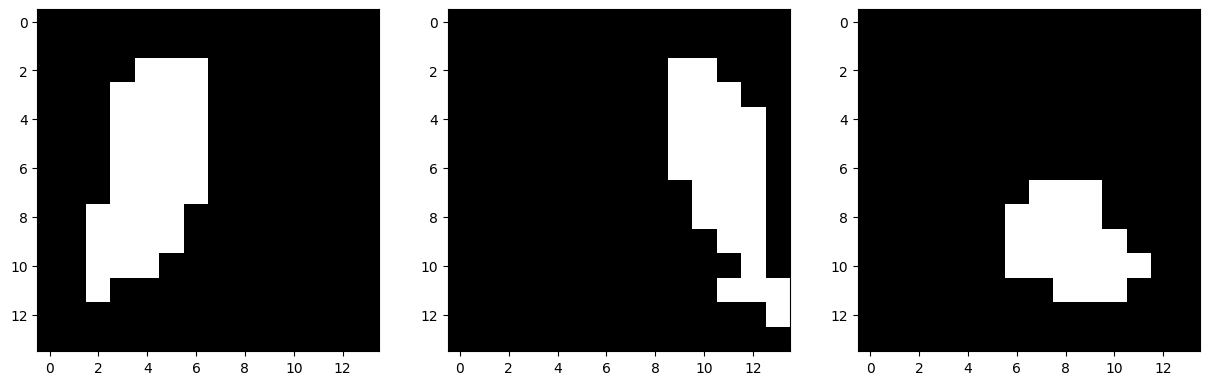

In [220]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(left_lung_mask_interpolate.cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(right_lung_mask_interpolate.cpu().numpy(), cmap="gray")

plt.subplot(1, 3, 3)
plt.imshow(heart_mask_interpolate.cpu().numpy(), cmap="gray")

plt.show()

In [174]:
left_lung_features_masked = features * left_lung_mask_interpolate
right_lung_features_masked = features * right_lung_mask_interpolate
heart_features_masked = features * heart_mask_interpolate

In [175]:
left_lung_features_masked.shape

torch.Size([1, 1024, 14, 14])

In [176]:
left_lung_features_masked = components["layer4"](left_lung_features_masked)
right_lung_features_masked = components["layer4"](right_lung_features_masked)
heart_features_masked = components["layer4"](heart_features_masked)

In [177]:
left_lung_features_masked.shape

torch.Size([1, 2048, 7, 7])

In [178]:
left_lung_features_masked = (
    components["avgpool"](left_lung_features_masked).squeeze(-1).squeeze(-1)
)
right_lung_features_masked = (
    components["avgpool"](right_lung_features_masked).squeeze(-1).squeeze(-1)
)
heart_features_masked = (
    components["avgpool"](heart_features_masked).squeeze(-1).squeeze(-1)
)

In [179]:
left_lung_features_masked.shape

torch.Size([1, 2048])

In [188]:
# Check min and max values of embedding
print(
    "Left lung min and max values:",
    left_lung_features_masked.min().item(),
    left_lung_features_masked.max().item(),
)

Left lung min and max values: 0.15783435106277466 1.003936767578125

In [181]:
# Calculate cosine similarity between left and right lung embeddings after attention pooling
left_lung_embs = left_lung_features_masked.cpu().detach().numpy()
right_lung_embs = right_lung_features_masked.cpu().detach().numpy()

print(
    cosine_similarity(
        left_lung_embs.mean(axis=0).reshape(1, -1),
        right_lung_embs.mean(axis=0).reshape(1, -1),
    )
)

# Calculate cosine similarity between left lung and heart embeddings after attention pooling
heart_embs = heart_features_masked.cpu().detach().numpy()

print(
    cosine_similarity(
        left_lung_embs.mean(axis=0).reshape(1, -1),
        heart_embs.mean(axis=0).reshape(1, -1),
    )
)

# Calculate cosine similarity between right lung and heart embeddings after attention pooling

print(
    cosine_similarity(
        right_lung_embs.mean(axis=0).reshape(1, -1),
        heart_embs.mean(axis=0).reshape(1, -1),
    )
)

[[0.9921495]]

[[0.99201465]]

[[0.9921862]]

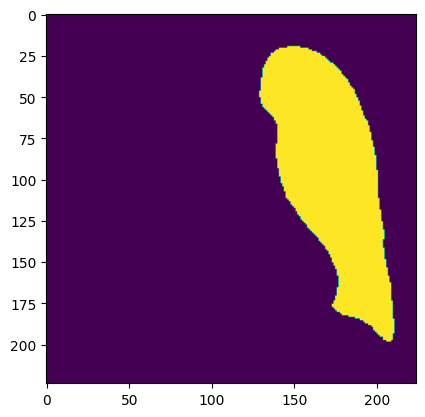

In [182]:
plt.imshow(right_lung_mask)

### Plot TSNE


In [278]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")

In [279]:
def load_region_embs(out_dir):
    out_dir = Path(out_dir)
    emb_files = list(out_dir.glob("region_embs/embs_*.npz"))
    all_embs = []
    for emb_file in emb_files:
        data = np.load(emb_file, allow_pickle=True)
        all_embs.extend(data["arr_0"])
    emb_map = pd.read_feather(out_dir / "region_embs/region_emb_mapping.feather")
    return all_embs, emb_map


In [280]:
embeddings, emb_map = load_region_embs("C:/Users/DryLab/Desktop/ViLLA/data/open-i/")

In [281]:
emb_map

,image_id,file,file_id
0,0,embs_2390,0
1,1,embs_2390,1
2,2,embs_2390,2
3,4,embs_2390,3
4,5,embs_2390,4
...,...,...,...
2383,3792,embs_3796,883
2384,3793,embs_3796,884
2385,3794,embs_3796,885
2386,3795,embs_3796,886


In [282]:
reshaped_embeddings = np.array(embeddings).reshape(len(embeddings), -1, 1024)

In [283]:
reshaped_embeddings.shape

(2388, 3, 1024)

In [284]:
np.array(embeddings[0]).reshape(-1, 1024).shape

(3, 1024)

In [285]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def plot_tsne(embeddings, emb_map, perplexity=30, n_iter=1000, random_state=42):
    # Flatten embeddings if necessary
    embeddings = np.array([emb.flatten() for emb in embeddings])

    # Perform t-SNE
    tsne = TSNE(
        n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=random_state
    )
    tsne_result = tsne.fit_transform(embeddings)

    # Plot the result
    # plt.figure(figsize=(10, 10))
    # plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=2, cmap="Spectral")
    # plt.title("t-SNE of Region Embeddings")
    # plt.show()

    return tsne_result


In [286]:
tsne_results = plot_tsne(embeddings, emb_map)

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [287]:
tsne_results.shape

(2388, 2)

In [288]:
labels = np.array([label for sublist in df["region_labels"] for label in sublist])
labels.shape

(7164, 1)

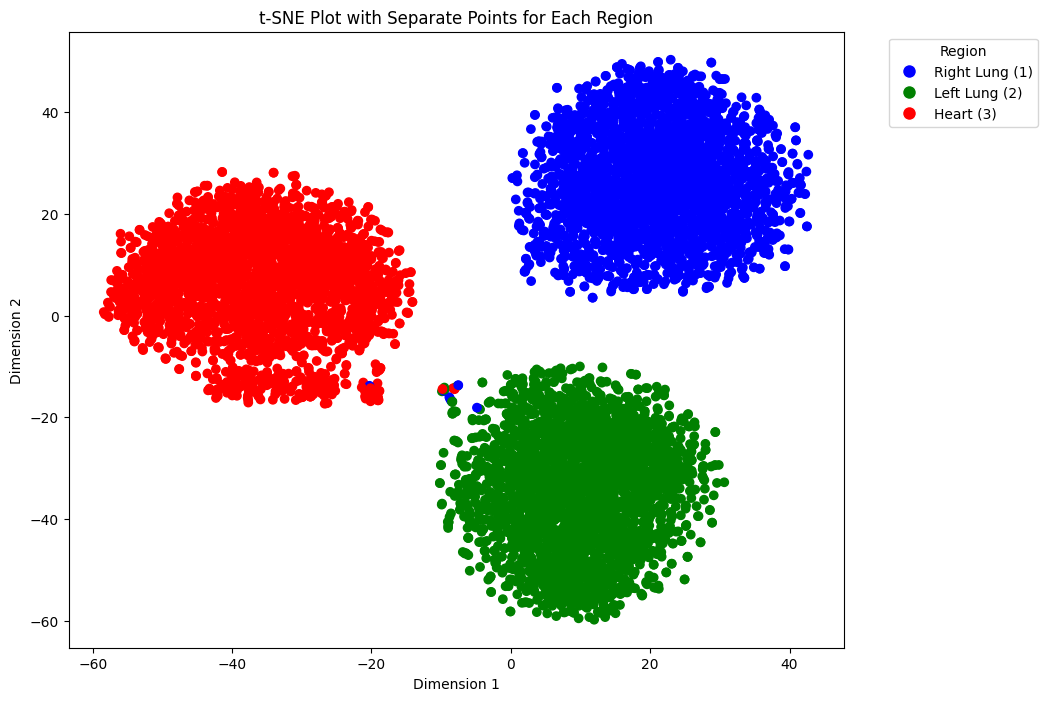

In [289]:
import matplotlib.pyplot as plt

flattened_embeddings = reshaped_embeddings.reshape(-1, 1024)

# Perform t-SNE on the flattened embeddings
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(flattened_embeddings)

# Map the labels to colors
labels = labels.reshape(-1)
color_map = {1: "blue", 2: "green", 3: "red"}
colors = [color_map[label] for label in labels]

# Create the t-SNE plot
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)

# Add a custom legend
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor=color_map[lbl], markersize=10
    )
    for lbl in color_map
]
plt.legend(
    handles,
    ["Right Lung (1)", "Left Lung (2)", "Heart (3)"],
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Add titles and labels
plt.title("t-SNE Plot with Separate Points for Each Region")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Show the plot
plt.show()


C:\Users\DryLab\AppData\Local\Temp\ipykernel_4040\58532624.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attr_to_emb = torch.load("C:/Users/DryLab/Desktop/ViLLA/data/o

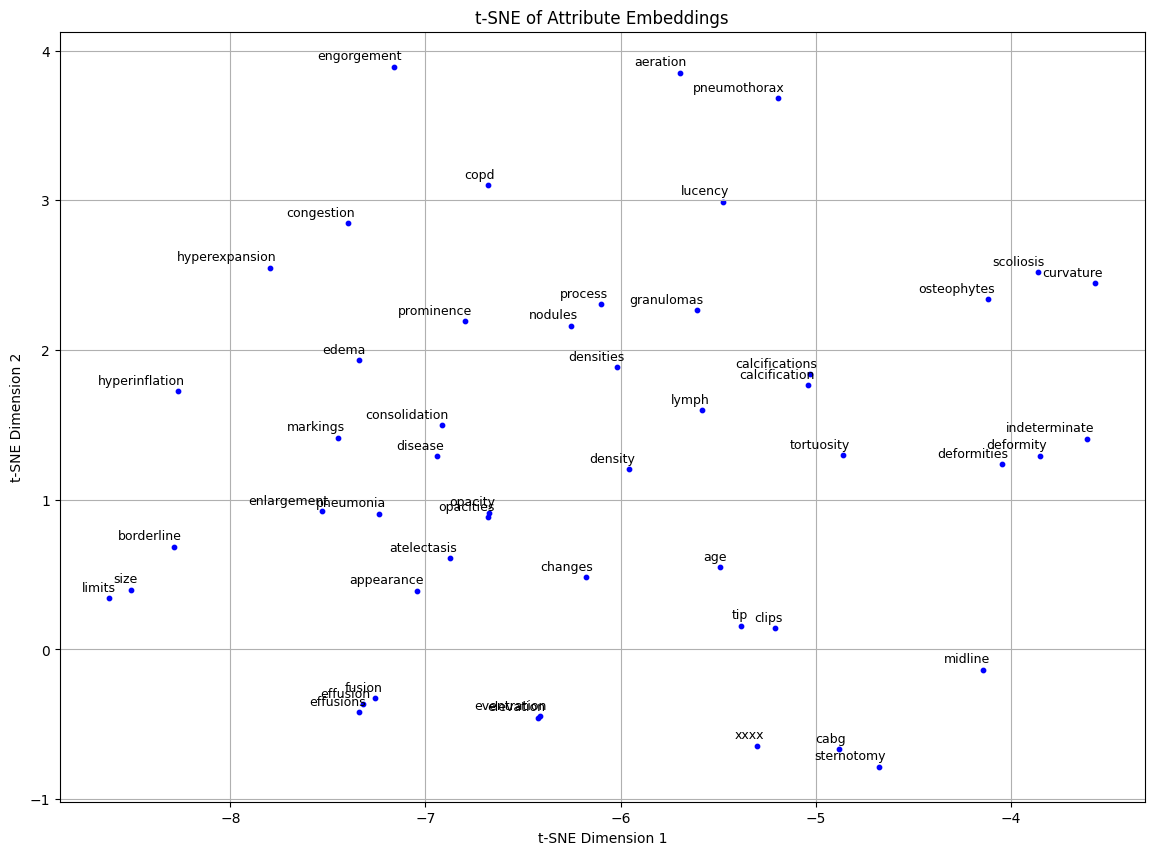

In [97]:
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

# Load the attribute embeddings
attr_to_emb = torch.load("C:/Users/DryLab/Desktop/ViLLA/data/open-i/attr_embs.pth")
attributes = list(attr_to_emb.keys())
attribute_embeddings = np.array([attr_to_emb[attr] for attr in attributes])

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(attribute_embeddings)

# Create the plot
plt.figure(figsize=(14, 10))

# Plot the points
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], color="blue", s=10
)  # s sets the point size

# Add labels with slight offsets
for i, attribute in enumerate(attributes):
    plt.annotate(
        attribute,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        textcoords="offset points",
        xytext=(5, 5),  # Adjust this to move labels
        ha="right",  # Horizontal alignment
        fontsize=9,  # Font size can be adjusted here
    )

plt.title("t-SNE of Attribute Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

### Check Mapping Results


In [82]:
mapping_train = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/checkpoints/mimic_stage1/runs/Sep02_10-55-53_DryLab/mapping_train.feather"
)

mapping_train = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/checkpoints/mimic_stage1/mapping_train.feather"
)

In [83]:
mapping_train

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_report,text,sentences,attributes,split,assigned_attributes,assigned_text
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[132, 20, 211, 166], [16, 19, 105, 184], [83,...","[[1], [2], [3]]",3,2016.02.03\nNormal heart size and configur...,normal heart size and configuration sharp cos...,[ normal heart size and configuration sharp co...,"[enlargement, infiltrations]",train,"[[], [enlargement, infiltrations], []]","[, suspicious enlargement of right hilum perib..."
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[111, 16, 207, 192], [22, 24, 90, 166], [85, ...","[[1], [2], [3]]",3,Tortuous thoracic aorta and cardiomegaly. \n I...,tortuous thoracic aorta and cardiomegaly . int...,"[tortuous thoracic aorta and cardiomegaly ., i...","[infiltration, kyphoscoliosis, opacities]",train,"[[], [kyphoscoliosis], [infiltration, opacities]]","[, kyphoscoliosis of t - l spine, interstitial..."
2,2,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[127, 18, 201, 206], [27, 21, 105, 170], [94,...","[[1], [2], [3]]",3,2016.03.12\nS/P tracheostomy \nIncreased in...,s / p tracheostomy increased infiltration ove...,[ s / p tracheostomy increased infiltration ov...,[infiltration],train,"[[], [], [infiltration]]","[, , s / p tracheostomy increased infiltration..."
3,3,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[126, 11, 201, 171], [9, 9, 99, 165], [78, 89...","[[1], [2], [3]]",3,2016.01.06\nNormal heart size and configur...,normal heart size and configuration . peribro...,"[ normal heart size and configuration ., perib...","[formation, infiltration]",train,"[[formation], [], [infiltration]]",[lower lungs interstitial infiltration over ri...
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[132, 21, 210, 189], [20, 19, 104, 154], [77,...","[[1], [2], [3]]",3,Consolidation and alveolar infiltration in the...,consolidation and alveolar infiltration in the...,[consolidation and alveolar infiltration in th...,"[borderline, consolidation, infiltration]",train,"[[], [consolidation], [borderline, infiltration]]","[, consolidation and alveolar infiltration in ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,92,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[122, 35, 202, 182], [18, 38, 93, 181], [83, ...","[[1], [2], [3]]",3,2016.02.29\nChange position to sitting. \n...,change position to sitting . tortuous aortic ...,"[ change position to sitting ., tortuous aorti...","[arteriosclerosis, calcification, change, form...",train,"[[calcification, change, formation], [arterios...",[tortuous aortic arch with intimal calcificati...
93,93,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[125, 14, 201, 185], [8, 14, 100, 143], [79, ...","[[1], [2], [3]]",3,Elevation of the left hemidiaphragm\nIncreased...,elevation of the left hemidiaphragm increased ...,[elevation of the left hemidiaphragm increased...,"[elevation, infiltration]",train,"[[], [elevation], [infiltration]]","[, elevation of the left hemidiaphragm increas..."
94,94,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[129, 19, 201, 173], [29, 20, 104, 176], [87,...","[[1], [2], [3]]",3,2019-11-26\nThe heart shadow is normal in...,the heart shadow is normal in size .,[ the heart shadow is normal in size .],[shadow],train,"[[], [], [shadow]]","[, , the heart shadow is normal in size]"
95,95,"[224, 224]",C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD 

In [85]:
mapping_train.iloc[3]

image_id                                                               3
image_size                                                    [224, 224]
image_filepath         C:/Users/DryLab/Desktop/ViLLA/Xray/X ray/CD pn...
region_coord           [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
region_bbox            [[126, 11, 201, 171], [9, 9, 99, 165], [78, 89...
region_labels                                            [[1], [2], [3]]
num_regions                                                            3
text_report            2016.01.06\nNormal  heart  size  and  configur...
text                    normal heart size and configuration . peribro...
sentences              [ normal heart size and configuration ., perib...
attributes                                     [formation, infiltration]
split                                                              train
assigned_attributes                    [[formation], [], [infiltration]]
assigned_text          [lower lungs interstitial in

In [86]:
mapping_train.iloc[3]["attributes"]

array(['formation', 'infiltration'], dtype=object)

In [87]:
mapping_train.iloc[3].assigned_text

array(['lower lungs interstitial infiltration over right lower chest degenerative change of thoracolumbar spine with spurs formation',
       '',
       'lower lungs interstitial infiltration over right lower chest degenerative change of thoracolumbar spine with spurs formation'],
      dtype=object)

In [88]:
mapping_train.iloc[3].assigned_attributes

array([array(['formation'], dtype=object), array([], dtype=object),
       array(['infiltration'], dtype=object)], dtype=object)

In [89]:
mapping_train.iloc[3].attributes

array(['formation', 'infiltration'], dtype=object)

In [90]:
mapping_train.iloc[3].text

' normal heart size and configuration . peribronchial thickening at bil . lower lungs interstitial infiltration over right lower chest degenerative change of thoracolumbar spine with spurs formation . osteoporotic change of visible bony structure'

In [91]:
from collections import defaultdict

import pandas as pd

# Initialize counters for empty findings
empty_counts = defaultdict(int)  # Using defaultdict to avoid key errors

# Loop through all rows in the dataframe
for index, row in mapping_train.iterrows():
    mappings = row["assigned_text"]

    # Iterate over each region
    for i in range(len(mappings)):
        region_attributes = mappings[i]
        if not region_attributes:  # Check if the region's attribute list is empty
            empty_counts[i + 1] += (
                1  # Increment empty count for the corresponding region
            )

# Print total empty labels for each region
print("Total empty labels for each region:")
for region, count in empty_counts.items():
    print(f"REGION {region}: {count} empty findings")


Total empty labels for each region:

REGION 1: 62 empty findings

REGION 3: 22 empty findings

REGION 2: 48 empty findings

In [92]:
import matplotlib.patches as patches


def plot_bounding_boxes_for_index(
    df, index, image_column="image_filepath", bbox_column="region_bbox"
):
    # Load the image using the index
    image_path = df[image_column].iloc[index]
    image = Image.open(image_path).convert("L")
    image = image.resize((224, 224))

    # Extract the bounding boxes
    bounding_boxes = df[bbox_column].iloc[index]

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray")

    # Unpack the bounding boxes
    left_lung_bbox = bounding_boxes[0]
    right_lung_bbox = bounding_boxes[1]
    heart_bbox = bounding_boxes[2]

    # Define bounding boxes' colors
    colors = ["r", "g", "b"]  # Red for right lung, Green for left lung, Blue for heart

    # Create rectangles for each bounding box and add them to the plot
    for bbox, color in zip([left_lung_bbox, right_lung_bbox, heart_bbox], colors):
        if not np.array_equal(
            bbox, [0, 0, 0, 0]
        ):  # Skip if the bbox is just a placeholder
            rect = patches.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)

    # Hide axis and show the plot
    plt.title(f"Bounding Boxes for Image {index}")
    plt.axis(False)
    plt.show()

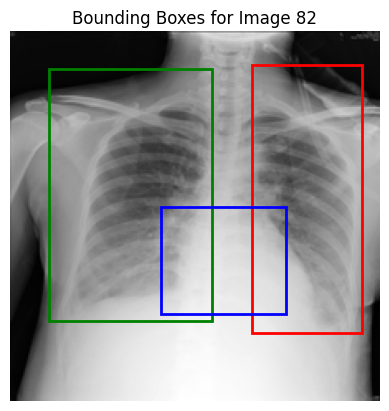

Original Text Report: bronchopneumonia at lll retrocardiac portion . non specific mild peribronchial linear 
reticular opacities : may be mild pulmonary congestion and coexisting mild peribronchial viral interstitial changes
.

Original Attributes: ['bronchopneumonia' 'opacities']

REGION-ATTRIBUTE PAIRS 82:

REGION 1 is empty!

REGION 2 is empty!

REGION 3: bronchopneumonia at lll retrocardiac portion . non specific mild peribronchial linear reticular 
opacities : may be mild pulmonary congestion and coexisting mild peribronchial viral interstitial changes

REGION 3 ATTRIBUTES: ['bronchopneumonia' 'opacities']

In [96]:
import random

import matplotlib.pyplot as plt

index = random.randint(0, len(mapping_train) - 1)

plot_bounding_boxes_for_index(mapping_train, index)

print(f"Original Text Report: {mapping_train['text'].iloc[index]}")
print(f"Original Attributes: {mapping_train['attributes'].iloc[index]}")
print(f"REGION-ATTRIBUTE PAIRS {index}:")

mappings = mapping_train["assigned_text"].values[index]
for i in range(len(mappings)):
    if not mappings[i]:
        print(f"\tREGION {i+1} is empty!")
    else:
        print(f"\tREGION {i+1}:", mappings[i])
        print(
            f"\tREGION {i+1} ATTRIBUTES:",
            mapping_train["assigned_attributes"].values[index][i],
        )


In [220]:
mapping_train.text_filepath.iloc[424]

'C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i/data/ecgen-radiology-txt\\CXR1820_IM-0532-1001.txt'

In [224]:
mapping_train = pd.read_feather(
    "C:/Users/DryLab/Desktop/ViLLA/checkpoints/docmnist_stage1/mapping_val.feather"
)

In [225]:
mapping_train.iloc[24]

image_id                                                           10203
image_size                                                      [84, 84]
image_filepath         C:\Users\DryLab\Desktop\ViLLA\data\docmnist_30...
region_coord           [[0, 0, 28, 28], [28, 0, 56, 28], [56, 0, 84, ...
num_regions                                                            9
split                                                                val
text                   the shape size is small . the image is blue . ...
digit_label            [four, seven, one, four, eight, three, zero, n...
color_label            [blue, purple, blue, purple, purple, purple, g...
shape_label            [circle, rectangle, rectangle, None, rectangle...
size_label             [large, large, large, None, small, small, larg...
reg_to_attr            [[four, blue, circle, large], [seven, purple, ...
attributes             [purple, seven, yellow, circle, one, small, bl...
assigned_attributes    [[seven, circle, blue, large

In [226]:
mapping_train.iloc[24].attributes

array(['purple', 'seven', 'yellow', 'circle', 'one', 'small', 'blue',
       'green', 'large', 'three', 'eight', 'nine', 'four', 'rectangle',
       'zero'], dtype=object)

In [227]:
mapping_train.iloc[24].assigned_attributes

array([array(['seven', 'circle', 'blue', 'large', 'eight', 'four'], dtype=object),
       array(['purple', 'seven', 'one', 'small', 'rectangle'], dtype=object),
       array(['seven', 'one', 'blue', 'large', 'eight', 'rectangle'],
             dtype=object)                                           ,
       array(['purple', 'four'], dtype=object),
       array(['purple', 'seven', 'circle', 'one', 'small', 'eight', 'four'],
             dtype=object)                                                  ,
       array(['purple', 'three'], dtype=object),
       array(['circle', 'green', 'zero'], dtype=object),
       array(['seven', 'yellow', 'eight', 'nine', 'rectangle'], dtype=object),
       array(['blue', 'four'], dtype=object)], dtype=object)

Original Text Report: there is a rectangle . the image has a circle . the digit appears to be blue . the image has 
a rectangle . the digit appears to be three . the shape size is large . there is an image showing a zero . the 
digit appears to be six . there is an image showing a seven . the number is a four . the color is purple . the 
digit appears to be seven . the color is green . there is a purple image . the shape is a rectangle . there is a 
green image . the image shows a seven . there is a circle . the shape is large . there is an image showing a six . 
the shape is a circle . the color is blue

Original Attributes: ['seven' 'six' 'circle' 'blue' 'green' 'large' 'three' 'zero' 'purple'
 'rectangle' 'four']

REGION-ATTRIBUTE PAIRS:

REGION 1: the image shows a seven . there is a circle

REGION 1 ATTRIBUTES: ['seven' 'circle']

REGION 2: there is a circle . the color is blue . the shape is large . the digit appears to be three

REGION 2 ATTRIBUTES: ['circle' 'blue' 'large' 'three']

REGION 3: there is a circle . there is a green image

REGION 3 ATTRIBUTES: ['circle' 'green']

REGION 4: the image shows a seven . there is a circle . the shape is large . there is an image showing a 
zero . there is a purple image

REGION 4 ATTRIBUTES: ['seven' 'circle' 'large' 'zero' 'purple']

REGION 5: there is a purple image

REGION 5 ATTRIBUTES: ['purple']

REGION 6: there is a green image . there is a rectangle . the number is a four

REGION 6 ATTRIBUTES: ['green' 'rectangle' 'four']

REGION 7: there is a circle . there is a green image . the shape is large

REGION 7 ATTRIBUTES: ['circle' 'green' 'large']

REGION 8: there is an image showing a six . the shape is large . there is a purple image . there is a 
rectangle

REGION 8 ATTRIBUTES: ['six' 'large' 'purple' 'rectangle']

REGION 9: there is a green image . the shape is large . there is a rectangle

REGION 9 ATTRIBUTES: ['green' 'large' 'rectangle']

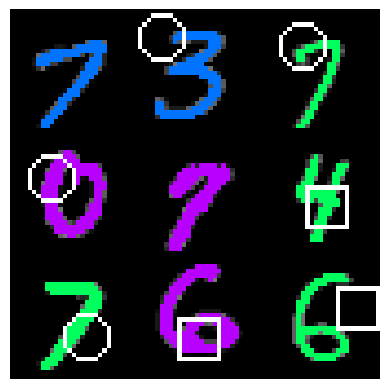

In [228]:
import random

index = random.randint(0, len(mapping_train) - 1)

img = sparse.load_npz(mapping_train["image_filepath"].iloc[index]).todense() / 255
plt.imshow(img.transpose(1, 2, 0))
plt.axis(False)
print(f"Original Text Report: {mapping_train['text'].iloc[index]}")
print(f"Original Attributes: {mapping_train['attributes'].iloc[index]}")
print("REGION-ATTRIBUTE PAIRS:")
mappings = mapping_train["assigned_text"].values[index]
for i in range(len(mappings)):
    print(f"\tREGION {i+1}:", mappings[i])
    print(
        f"\tREGION {i+1} ATTRIBUTES:",
        mapping_train["assigned_attributes"].values[index][i],
    )

In [129]:
df = pd.read_feather("C:/Users/DryLab/Desktop/ViLLA/data/open-i/annotations.feather")

In [105]:
def assign_sents_to_attributes(text, a):
    text = [t.lower() for t in text]
    selected_sents = []
    for i in range(len(text)):
        if f"{a}" in text[i]:
            selected_sents.append(i)
    return np.random.choice(selected_sents)

In [119]:
for idx, row in df.iterrows():
    attribute_to_text = {}
    text = [x.strip() for x in row["text"].split(".") if len(x) > 3]
    for a in row["attributes"]:
        assigned_sents = assign_sents_to_attributes(text, a)
        attribute_to_text[a] = text[assigned_sents]

In [120]:
attribute_to_text

{'density': 'increased size of density in the left cardiophrenic xxxx',
 'size': 'increased size of density in the left cardiophrenic xxxx'}

In [121]:
attribute_to_text

{'density': 'increased size of density in the left cardiophrenic xxxx',
 'size': 'increased size of density in the left cardiophrenic xxxx'}

In [130]:
df

,image_id,image_size,image_filepath,region_coord,region_bbox,region_labels,num_regions,text_filepath,text,sentences,attributes,split
0,0,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[7, 16, 111, 175], [142, 14, 223, 159], [87, ...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is within normal limits...,[the cardiac silhouette is within normal limit...,"[atelectasis, limits, opacity]",train
1,1,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 13, 92, 172], [123, 12, 208, 176], [72, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,the cardiac silhouette is within normal limits...,[the cardiac silhouette is within normal limit...,"[atelectasis, limits, opacity]",train
4,4,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[17, 26, 92, 174], [117, 21, 213, 180], [78, ...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there appears to be air within this which coul...,[there appears to be air within this which cou...,"[atelectasis, calcification, density, opacity]",train
5,5,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[16, 25, 102, 178], [126, 25, 203, 183], [85,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,there is no pleural effusion or pneumothorax ....,[there is no pleural effusion or pneumothorax ...,[changes],train
8,8,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[24, 11, 103, 201], [130, 11, 197, 198], [91,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"the lungs are clear , without evidence of acut...","[the lungs are clear , without evidence of acu...",[changes],train
...,...,...,...,...,...,...,...,...,...,...,...,...
3792,3792,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[26, 11, 107, 172], [132, 18, 203, 194], [84,...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"no focal consolidation , pneumothorax , or ple...","[no focal consolidation , pneumothorax , or pl...",[disease],val
3793,3793,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[25, 10, 98, 199], [125, 8, 193, 210], [88, 1...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,cardiomediastinal silhouette is within normal ...,[cardiomediastinal silhouette is within normal...,[limits],val
3794,3794,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[24, 1, 93, 158], [124, 2, 196, 185], [85, 76...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,cardiomediastinal silhouette is within normal ...,[cardiomediastinal silhouette is within normal...,[limits],val
3795,3795,"[224, 224]",C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[31, 9, 99, 160], [123, 13, 199, 188], [88, 9...","[[1], [2], [3]]",3,C:/Users/DryLab/Desktop/ConVIRT/Dataset/open-i...,clear lungs .trachea is midline .no pneumothor...,"[clear lungs .trachea is midline .no, pneumoth...",[midline],val
